<a href="https://colab.research.google.com/github/gkv856/KaggleData/blob/main/ANN_pyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split


from IPython import display
display.set_matplotlib_formats("svg")


# Create Data

In [73]:
def get_random_data(random_state=42):
  np.random.seed(random_state)
  nPerClust = 200

  th = np.linspace(0, 4*np.pi, nPerClust)
  r1 = 10
  r2 = 15

  a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
      r1*np.sin(th) + np.random.randn(nPerClust)*3]


  b = [r2*np.cos(th) + np.random.randn(nPerClust)*3,
      r2*np.sin(th) + np.random.randn(nPerClust)*3]

  # true labels
  labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

  data_np = np.hstack((a, b)).T

  data = torch.tensor(data_np).float()
  labels = torch.tensor(labels_np).float()

  return data, labels


In [74]:
def plot_data(data, labels):
  # display the data

  fig = plt.figure(figsize=(5, 5))

  plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], "bs")
  plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], "ko")
  plt.title("The qwerties doughnuts!")
  plt.xlabel("dim1")
  plt.ylabel("dim2")

  plt.show()

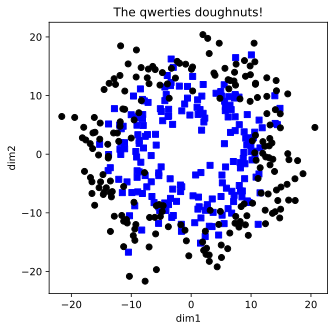

In [75]:
data, labels = get_random_data()
plot_data(data, labels)


# Data prepration

In [76]:
train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                                    labels,
                                                                    test_size=.2,
                                                                    random_state=42)
len(train_data), len(test_data), len(train_labels), len(test_labels)

(320, 80, 320, 80)

In [77]:
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [78]:
BATCH_SIZE = 16
train_ds = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_ds = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])


In [79]:
class TheModelClass(nn.Module):
  def __init__(self, dropout_rate):
    super().__init__()

    # layers
    self.input = nn.Linear(2, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)

    # parameters
    self.dr = dropout_rate

  # forward pass
  def forward(self, x):

    x = F.relu(self.input(x))

    # self.training which means during the training it will be True and 
    # False during the eval mode
    x = F.dropout(x, p=self.dr, training=self.training)
    
    x = F.relu(self.hidden(x))
    x = F.dropout(x, p=self.dr, training=self.training)
    
    x = self.output(x)

    return x


In [80]:
tmp_model = TheModelClass(.25)

# running dummy data through the model
tmp_data = torch.randn((5, 2))
yhat = tmp_model(tmp_data)
yhat

tensor([[ 0.2703],
        [-0.0408],
        [-0.0128],
        [-0.1306],
        [ 0.1611]], grad_fn=<AddmmBackward>)

In [81]:
def create_model(dropout_rate=0.10, lr=0.002):
  # grab the instance of the model
  ANNQC = TheModelClass(dropout_rate)

  # loss function, with logit bkz 
  # we did not apply sigmoid at the output layer of the model
  loss_func = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(), lr=lr)

  return ANNQC, loss_func, optimizer 

In [82]:
def get_accuracy(y_preds, y_real):
  tf_preds = ((y_preds>0.5)==y_real).float() # true/false to 0/1
  acc = 100 * torch.mean(tf_preds).item() # .item to get val out of tensor
  return acc 

In [83]:
def create_and_train_model(epochs=1000, dropout_rate=0.10):
  # initialize accuracies as empties
  train_acc = []
  test_acc = []
  ANNQC, loss_func, optimizer = create_model(dropout_rate=dropout_rate)

  for epoch in range(epochs):
    # switch training mode on
    ANNQC.train()
    batch_acc = []

    for X, y in train_ds:  
      # forward pass
      y_hat = ANNQC(X)
      loss = loss_func(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute accuracy for this batch
      batch_acc.append(get_accuracy(y_hat, y))

    # calculating train_acc or epoch acc by taking mean of batch acc
    train_acc.append(np.mean(batch_acc))

    # checking test accuracy
    ANNQC.eval() # activating test mode = off training mode
    X_test, y_test = next(iter(test_ds))
    y_hat_test = ANNQC(X_test)
    test_acc.append(get_accuracy(y_hat_test, y_test))

  return ANNQC, train_acc, test_acc

In [84]:
dr = 0.0
epochs = 500
ANNQC, train_acc, test_acc = create_and_train_model(epochs, dr)

In [85]:
def smooth_data_for_visualization(x, k=5):
  return np.convolve(x, np.ones(k)/k, mode="same")

In [86]:
def plot_model_acc_loss(train_acc, test_acc, dr=0, smooth=False):
  fig = plt.figure(figsize=(10, 5))

  if smooth:
    train_acc = smooth_data_for_visualization(train_acc)
    test_acc = smooth_data_for_visualization(test_acc)
    
  plt.plot(train_acc, "bs-")
  plt.plot(test_acc, "ro-")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")
  plt.legend(["Train", "Test"])
  plt.title(f"Dropout rate = {dr}")
  plt.show()
  

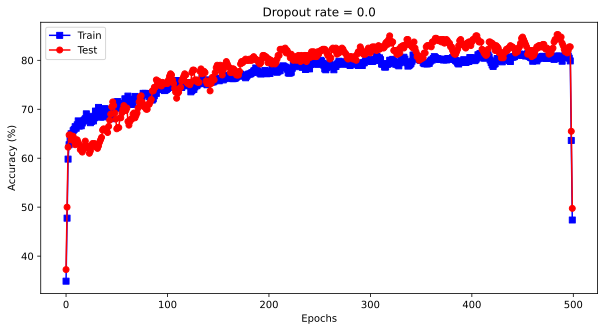

In [87]:
plot_model_acc_loss(train_acc, test_acc, dr=dr, smooth=True)

# Running experiments 

In [88]:
n_drs = 10
dropout_rates = np.arange(n_drs)/n_drs # bw 0, 1
results = np.zeros((n_drs, 2)) # shape len x 2

for di in range(n_drs):
  epochs = 1000
  ANNQC, train_acc, test_acc = create_and_train_model(epochs, dr)

  # getting acc of last 100 epochs
  results[di, 0] = np.mean(train_acc[-100: ])
  results[di, 1] = np.mean(test_acc[-100: ])
  

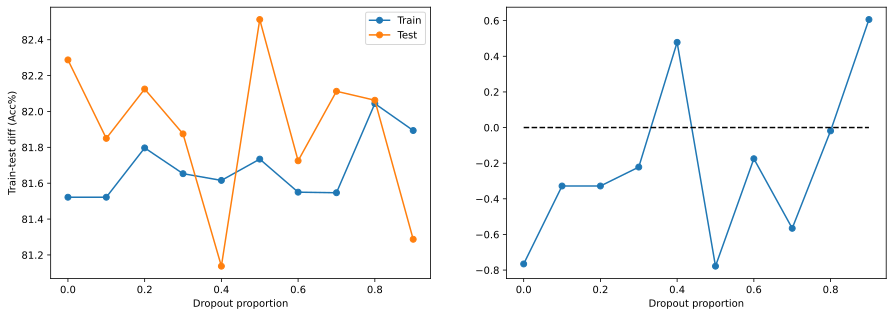

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(dropout_rates, results, "o-")
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Average accuracy")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropout_rates, -np.diff(results, axis=1), "o-")
ax[1].plot([0, .9], [0, 0], "k--")
ax[1].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Train-test diff (Acc%)")
# ax[0].legend(["Train", "Test"])
plt.show()

